# Things to do: 
- Lag Variable function updates
- Plotting total demand by 30min and group by week day
- Outlier handling: How we want to approach outliers found (Trimming, Capping, Discretization) 
- Plot demand vs season

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# pd.options.display.max_columns = 50
# pd.options.display.max_rows = 50
# pd.options.display.width = 120
# pd.options.display.float_format = '{:.2f}'.format

# Loading Data
Loading data from the processed and combined csv file into the dataframe to commence preprocessing and cleansing.

In [3]:
source_data = r'./../data/NSW/processed_data.csv'

In [4]:
source_df = pd.read_csv(source_data).set_index('Unnamed: 0')
# print(source_df)

Checking if there are any NA values that we need to take into considering or drop the columns completely since data has been smoothed.

In [5]:
print(source_df.isna().sum())

PREDISPATCHSEQNO              0
PERIODID                      0
FORECASTDEMAND                0
TOTALDEMAND                   0
TEMPERATURE                   0
totaldemand                   0
rrp                           0
smoothed_FORECASTDEMAND       0
smoothed_TOTALDEMAND          0
smoothed_TEMPERATURE          0
FORECASTDEMAND_daily         33
TOTALDEMAND_daily            33
normalized_TOTALDEMAND        0
normalized_FORECASTDEMAND     0
normalized_TEMPERATURE        0
dtype: int64


In [6]:
print(source_df.columns)

Index(['PREDISPATCHSEQNO', 'PERIODID', 'FORECASTDEMAND', 'TOTALDEMAND',
       'TEMPERATURE', 'totaldemand', 'rrp', 'smoothed_FORECASTDEMAND',
       'smoothed_TOTALDEMAND', 'smoothed_TEMPERATURE', 'FORECASTDEMAND_daily',
       'TOTALDEMAND_daily', 'normalized_TOTALDEMAND',
       'normalized_FORECASTDEMAND', 'normalized_TEMPERATURE'],
      dtype='object')


In [7]:
print(source_df.dtypes)

PREDISPATCHSEQNO             float64
PERIODID                     float64
FORECASTDEMAND               float64
TOTALDEMAND                  float64
TEMPERATURE                  float64
totaldemand                  float64
rrp                          float64
smoothed_FORECASTDEMAND      float64
smoothed_TOTALDEMAND         float64
smoothed_TEMPERATURE         float64
FORECASTDEMAND_daily         float64
TOTALDEMAND_daily            float64
normalized_TOTALDEMAND       float64
normalized_FORECASTDEMAND    float64
normalized_TEMPERATURE       float64
dtype: object


In [8]:
updated_df = source_df

In [9]:
print(updated_df.index)

Index(['2010-01-01 00:30:00', '2010-01-01 01:00:00', '2010-01-01 01:30:00',
       '2010-01-01 02:00:00', '2010-01-01 02:30:00', '2010-01-01 03:00:00',
       '2010-01-01 03:30:00', '2010-01-01 04:00:00', '2010-01-01 04:30:00',
       '2010-01-01 05:00:00',
       ...
       '2021-03-17 19:30:00', '2021-03-17 20:00:00', '2021-03-17 20:30:00',
       '2021-03-17 21:00:00', '2021-03-17 21:30:00', '2021-03-17 22:00:00',
       '2021-03-17 22:30:00', '2021-03-17 23:00:00', '2021-03-17 23:30:00',
       '2021-03-18 00:00:00'],
      dtype='object', name='Unnamed: 0', length=194589)


In [10]:
updated_df.index=pd.to_datetime(updated_df.index)

Dropped Forecast_Daily and TotalDemand_daily - contained 33 N/A's.

In [11]:
updated_df.drop(['FORECASTDEMAND_daily','TOTALDEMAND_daily'],axis=1,inplace=True)

In [12]:
print(updated_df.isna().sum())

PREDISPATCHSEQNO             0
PERIODID                     0
FORECASTDEMAND               0
TOTALDEMAND                  0
TEMPERATURE                  0
totaldemand                  0
rrp                          0
smoothed_FORECASTDEMAND      0
smoothed_TOTALDEMAND         0
smoothed_TEMPERATURE         0
normalized_TOTALDEMAND       0
normalized_FORECASTDEMAND    0
normalized_TEMPERATURE       0
dtype: int64


In [13]:
updated_df

,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,TOTALDEMAND,TEMPERATURE,totaldemand,rrp,smoothed_FORECASTDEMAND,smoothed_TOTALDEMAND,smoothed_TEMPERATURE,normalized_TOTALDEMAND,normalized_FORECASTDEMAND,normalized_TEMPERATURE
Unnamed: 0,,,,,,,,,,,,,
2010-01-01 00:30:00,2.009123e+09,36.5,7680.510417,7809.31,22.9,7809.31,21.50,7699.974365,7781.995417,25.233333,-0.232608,-0.325943,0.916251
2010-01-01 01:00:00,2.009123e+09,37.0,7428.971370,7483.69,22.6,7483.69,20.98,7690.566078,7773.996250,25.266667,-0.483133,-0.518995,0.865312
2010-01-01 01:30:00,2.009123e+09,37.5,7084.802162,7117.23,22.5,7117.23,20.06,7681.336748,7766.966458,25.302083,-0.765079,-0.783139,0.848332
2010-01-01 02:00:00,2.009123e+09,38.0,6751.369600,6812.03,22.5,6812.03,17.93,7672.747139,7760.413125,25.335417,-0.999894,-1.039043,0.848332
2010-01-01 02:30:00,2.009123e+09,38.5,6484.270789,6544.33,22.4,6544.33,17.43,7665.716673,7756.316458,25.366667,-1.205856,-1.244036,0.831352
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17 22:00:00,2.021032e+09,34.0,7317.702687,7419.77,19.7,7419.77,32.00,7400.366626,7422.855208,19.712500,-0.532312,-0.604392,0.372894
2021-03-17 22:30:00,2.021032e+09,34.5,7266.887647,7417.91,19.5,7417.91,37.01,7399.723912,7424.357917,19.691667,-0.533743,-0.643392,0.338934
2021-03-17 23:00:00,2.021032e+09,35.0,7173.866522,7287.32,19.1,7287.32,34.49,7399.132502,7425.781458,19.666667,-0.634216,-0.714784,0.271015


In [14]:
print(updated_df.head())

                     PREDISPATCHSEQNO  PERIODID  FORECASTDEMAND  TOTALDEMAND  \
Unnamed: 0                                                                     
2010-01-01 00:30:00      2.009123e+09      36.5     7680.510417      7809.31   
2010-01-01 01:00:00      2.009123e+09      37.0     7428.971370      7483.69   
2010-01-01 01:30:00      2.009123e+09      37.5     7084.802162      7117.23   
2010-01-01 02:00:00      2.009123e+09      38.0     6751.369600      6812.03   
2010-01-01 02:30:00      2.009123e+09      38.5     6484.270789      6544.33   

                     TEMPERATURE  totaldemand    rrp  smoothed_FORECASTDEMAND  \
Unnamed: 0                                                                      
2010-01-01 00:30:00         22.9      7809.31  21.50              7699.974365   
2010-01-01 01:00:00         22.6      7483.69  20.98              7690.566078   
2010-01-01 01:30:00         22.5      7117.23  20.06              7681.336748   
2010-01-01 02:00:00         22.5  

# Feature Engineering

## DateTime Features
The following section creates date time features.

In [15]:
demand = updated_df.copy()
demand = demand[['totaldemand']]
demand.loc[:, 'dow'] = demand.index.dayofweek
demand.loc[:, 'doy'] = demand.index.dayofyear
demand.loc[:, 'year'] = demand.index.year
demand.loc[:, 'month'] = demand.index.month
demand.loc[:, 'quarter'] = demand.index.quarter
demand.loc[:, 'hour'] = demand.index.hour


In [16]:
print(demand.head())

                     totaldemand  dow  doy  year  month  quarter  hour
Unnamed: 0                                                            
2010-01-01 00:30:00      7809.31    4    1  2010      1        1     0
2010-01-01 01:00:00      7483.69    4    1  2010      1        1     1
2010-01-01 01:30:00      7117.23    4    1  2010      1        1     1
2010-01-01 02:00:00      6812.03    4    1  2010      1        1     2
2010-01-01 02:30:00      6544.33    4    1  2010      1        1     2


In [17]:
print(demand.iloc[45:60])

                     totaldemand  dow  doy  year  month  quarter  hour
Unnamed: 0                                                            
2010-01-01 23:00:00      8041.77    4    1  2010      1        1    23
2010-01-01 23:30:00      7782.68    4    1  2010      1        1    23
2010-01-02 00:00:00      7574.85    5    2  2010      1        1     0
2010-01-02 00:30:00      7343.30    5    2  2010      1        1     0
2010-01-02 01:00:00      7099.73    5    2  2010      1        1     1
2010-01-02 01:30:00      6779.80    5    2  2010      1        1     1
2010-01-02 02:00:00      6497.47    5    2  2010      1        1     2
2010-01-02 02:30:00      6347.69    5    2  2010      1        1     2
2010-01-02 03:00:00      6223.64    5    2  2010      1        1     3
2010-01-02 03:30:00      6182.07    5    2  2010      1        1     3
2010-01-02 04:00:00      6140.82    5    2  2010      1        1     4
2010-01-02 04:30:00      6224.48    5    2  2010      1        1     4
2010-0

Merge to the updated_df

In [18]:
print(demand.isna().sum())

totaldemand    0
dow            0
doy            0
year           0
month          0
quarter        0
hour           0
dtype: int64


In [19]:
print(demand.index)

DatetimeIndex(['2010-01-01 00:30:00', '2010-01-01 01:00:00',
               '2010-01-01 01:30:00', '2010-01-01 02:00:00',
               '2010-01-01 02:30:00', '2010-01-01 03:00:00',
               '2010-01-01 03:30:00', '2010-01-01 04:00:00',
               '2010-01-01 04:30:00', '2010-01-01 05:00:00',
               ...
               '2021-03-17 19:30:00', '2021-03-17 20:00:00',
               '2021-03-17 20:30:00', '2021-03-17 21:00:00',
               '2021-03-17 21:30:00', '2021-03-17 22:00:00',
               '2021-03-17 22:30:00', '2021-03-17 23:00:00',
               '2021-03-17 23:30:00', '2021-03-18 00:00:00'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=194589, freq=None)


In [20]:
final_df = pd.merge(updated_df, demand, left_index =True, right_index=True)

In [21]:
print(final_df)

                     PREDISPATCHSEQNO  PERIODID  FORECASTDEMAND  TOTALDEMAND  \
Unnamed: 0                                                                     
2010-01-01 00:30:00      2.009123e+09      36.5     7680.510417      7809.31   
2010-01-01 01:00:00      2.009123e+09      37.0     7428.971370      7483.69   
2010-01-01 01:30:00      2.009123e+09      37.5     7084.802162      7117.23   
2010-01-01 02:00:00      2.009123e+09      38.0     6751.369600      6812.03   
2010-01-01 02:30:00      2.009123e+09      38.5     6484.270789      6544.33   
...                               ...       ...             ...          ...   
2021-03-17 22:00:00      2.021032e+09      34.0     7317.702687      7419.77   
2021-03-17 22:30:00      2.021032e+09      34.5     7266.887647      7417.91   
2021-03-17 23:00:00      2.021032e+09      35.0     7173.866522      7287.32   
2021-03-17 23:30:00      2.021032e+09      35.5     7043.236857      7172.39   
2021-03-18 00:00:00      2.021032e+09   

In [22]:
print(final_df.isna().sum())

PREDISPATCHSEQNO             0
PERIODID                     0
FORECASTDEMAND               0
TOTALDEMAND                  0
TEMPERATURE                  0
totaldemand_x                0
rrp                          0
smoothed_FORECASTDEMAND      0
smoothed_TOTALDEMAND         0
smoothed_TEMPERATURE         0
normalized_TOTALDEMAND       0
normalized_FORECASTDEMAND    0
normalized_TEMPERATURE       0
totaldemand_y                0
dow                          0
doy                          0
year                         0
month                        0
quarter                      0
hour                         0
dtype: int64


In [23]:
print(final_df.index)

DatetimeIndex(['2010-01-01 00:30:00', '2010-01-01 01:00:00',
               '2010-01-01 01:30:00', '2010-01-01 02:00:00',
               '2010-01-01 02:30:00', '2010-01-01 03:00:00',
               '2010-01-01 03:30:00', '2010-01-01 04:00:00',
               '2010-01-01 04:30:00', '2010-01-01 05:00:00',
               ...
               '2021-03-17 19:30:00', '2021-03-17 20:00:00',
               '2021-03-17 20:30:00', '2021-03-17 21:00:00',
               '2021-03-17 21:30:00', '2021-03-17 22:00:00',
               '2021-03-17 22:30:00', '2021-03-17 23:00:00',
               '2021-03-17 23:30:00', '2021-03-18 00:00:00'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=194589, freq=None)


## Adding Season Data
Season data being added to the dataframe before the final_df is created and exported to csv.

In [24]:
final_df['season'] = final_df['month'].apply(lambda month: 1 if month in [12, 1, 2] else
                                  (2 if month in [3, 4, 5] else
                                  (3 if month in [6, 7, 8] else
                                  (4 if month in [9, 10, 11] else None))))

In [25]:
print(final_df.index)

DatetimeIndex(['2010-01-01 00:30:00', '2010-01-01 01:00:00',
               '2010-01-01 01:30:00', '2010-01-01 02:00:00',
               '2010-01-01 02:30:00', '2010-01-01 03:00:00',
               '2010-01-01 03:30:00', '2010-01-01 04:00:00',
               '2010-01-01 04:30:00', '2010-01-01 05:00:00',
               ...
               '2021-03-17 19:30:00', '2021-03-17 20:00:00',
               '2021-03-17 20:30:00', '2021-03-17 21:00:00',
               '2021-03-17 21:30:00', '2021-03-17 22:00:00',
               '2021-03-17 22:30:00', '2021-03-17 23:00:00',
               '2021-03-17 23:30:00', '2021-03-18 00:00:00'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=194589, freq=None)


In [26]:
final_df.head()

,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,TOTALDEMAND,TEMPERATURE,totaldemand_x,rrp,smoothed_FORECASTDEMAND,smoothed_TOTALDEMAND,smoothed_TEMPERATURE,...,normalized_FORECASTDEMAND,normalized_TEMPERATURE,totaldemand_y,dow,doy,year,month,quarter,hour,season
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:30:00,2.009123e+09,36.5,7680.510417,7809.31,22.9,7809.31,21.50,7699.974365,7781.995417,25.233333,...,-0.325943,0.916251,7809.31,4,1,2010,1,1,0,1
2010-01-01 01:00:00,2.009123e+09,37.0,7428.971370,7483.69,22.6,7483.69,20.98,7690.566078,7773.996250,25.266667,...,-0.518995,0.865312,7483.69,4,1,2010,1,1,1,1
2010-01-01 01:30:00,2.009123e+09,37.5,7084.802162,7117.23,22.5,7117.23,20.06,7681.336748,7766.966458,25.302083,...,-0.783139,0.848332,7117.23,4,1,2010,1,1,1,1
2010-01-01 02:00:00,2.009123e+09,38.0,6751.369600,6812.03,22.5,6812.03,17.93,7672.747139,7760.413125,25.335417,...,-1.039043,0.848332,6812.03,4,1,2010,1,1,2,1
2010-01-01 02:30:00,2.009123e+09,38.5,6484.270789,6544.33,22.4,6544.33,17.43,7665.716673,7756.316458,25.366667,...,-1.244036,0.831352,6544.33,4,1,2010,1,1,2,1


# Exporting Dataframe to CSV
The final dataframe is being exported to csv so that it can be used for additional analysis and modelling.

In [27]:
# final_df.to_csv(os.path.join('./../data/NSW', 'final_df.csv'))

## Degree Days

In [28]:
def Degree_Days2(df, HDD_ct=17, CDD_ct=19.5):
    Tbar = df.resample('24H', offset='21H').mean() # Mean from 9pm (day i-1) - 9pm (day i)
    DD = pd.DataFrame(index=df.index, columns=['HDD', 'CDD'])
    for i in range(0,Tbar.shape[0]):
        DD['HDD'].iloc[48*(i):48*(i+1)] = max(0, HDD_ct-Tbar.iloc[i])
        DD['CDD'].iloc[48*(i):48*(i+1)] = max(0, Tbar.iloc[i]-CDD_ct)
    return Tbar, DD

In [29]:
Degree_Days2(final_df['TEMPERATURE'])

(Unnamed: 0
 2009-12-31 21:00:00    25.263415
 2010-01-01 21:00:00    25.093750
 2010-01-02 21:00:00    19.943750
 2010-01-03 21:00:00    20.610417
 2010-01-04 21:00:00    22.425000
                          ...    
 2021-03-13 21:00:00    19.379167
 2021-03-14 21:00:00    17.135417
 2021-03-15 21:00:00    17.508333
 2021-03-16 21:00:00    19.747917
 2021-03-17 21:00:00    19.228571
 Freq: 24H, Name: TEMPERATURE, Length: 4095, dtype: float64,
                     HDD       CDD
 Unnamed: 0                       
 2010-01-01 00:30:00   0  5.763415
 2010-01-01 01:00:00   0  5.763415
 2010-01-01 01:30:00   0  5.763415
 2010-01-01 02:00:00   0  5.763415
 2010-01-01 02:30:00   0  5.763415
 ...                  ..       ...
 2021-03-17 22:00:00   0  4.420833
 2021-03-17 22:30:00   0  4.420833
 2021-03-17 23:00:00   0  4.420833
 2021-03-17 23:30:00   0  4.420833
 2021-03-18 00:00:00   0  4.420833
 
 [194589 rows x 2 columns])

In [30]:
Tbar, DD = Degree_Days2(final_df['TEMPERATURE'])

In [31]:
print(Tbar.isna().sum())

30


In [32]:
print(DD.isna().sum())

HDD    0
CDD    0
dtype: int64


In [33]:
print(DD['HDD'])

Unnamed: 0
2010-01-01 00:30:00    0
2010-01-01 01:00:00    0
2010-01-01 01:30:00    0
2010-01-01 02:00:00    0
2010-01-01 02:30:00    0
                      ..
2021-03-17 22:00:00    0
2021-03-17 22:30:00    0
2021-03-17 23:00:00    0
2021-03-17 23:30:00    0
2021-03-18 00:00:00    0
Name: HDD, Length: 194589, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


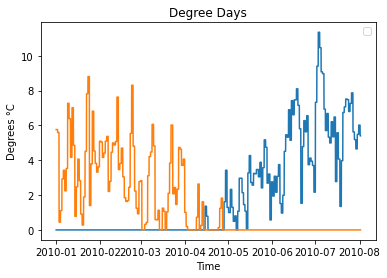

In [34]:
plt.plot(DD.iloc[1:10000])
plt.title("Degree Days")
plt.xlabel("Time")
plt.ylabel("Degrees °C")
plt.legend()
plt.show()

# Outliers
Outlier detection is a method used to find unusual or abnormal data points in a data set. 
Methods of treating outliers:
- Trimming: removing the data from the dataset
- Capping:For instance, if we decide on a specific value, any data point above or below that value is considered an outlier. 
- Discretization: create groups and categorise the outliers into specific group making them follow the same behavior as the other points in that group.

## Temperature
Outlier handling of temperature

In [35]:
temp_highest_allowed = round(final_df['TEMPERATURE'].mean() + 3*final_df['TEMPERATURE'].std(),2)
temp_lowest_allowed = round(final_df['TEMPERATURE'].mean() - 3*final_df['TEMPERATURE'].std(),2)
print('Highest Allowed:',temp_highest_allowed)
print('Lowest Allowed:',temp_lowest_allowed)

Highest Allowed: 35.17
Lowest Allowed: -0.16


In [37]:
temp_outliers = final_df[(final_df['TEMPERATURE']>temp_highest_allowed) | (final_df['TEMPERATURE']<temp_lowest_allowed)]
print('Total Rows:',len(temp_outliers))

Total Rows: 569


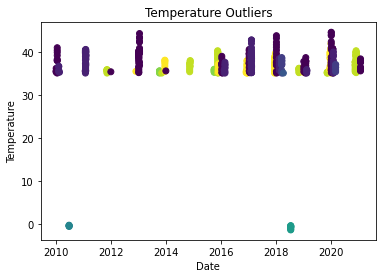

In [38]:
plt.scatter(temp_outliers.index, temp_outliers['TEMPERATURE'],c=temp_outliers['month'])
plt.title('Temperature Outliers')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()


#TO DO: Add month legend onto plot

##### High Temperature Values
Outliers were identified for temperature values and high temperature outliers are more frequent from Nov to March. Indicating that during this period predictions may be less accurate.

In [43]:
high_outliers = temp_outliers.loc[temp_outliers['TEMPERATURE']>temp_highest_allowed]
print(high_outliers['month'].value_counts())

#To DO: Create histogram for outliers for highest

1     209
2     129
11    100
12     81
3      20
10     14
4       1
Name: month, dtype: int64


##### Low Temperature Values
Lower tempature variations are far less those outliers observed for higher temperature variations. Lower tempature values can be found in June and July (Winter periods).

In [44]:
low_outliers = temp_outliers.loc[temp_outliers['TEMPERATURE']<temp_lowest_allowed]

In [45]:
print(low_outliers['month'].value_counts())
# TO DO: Create Histogram

7    10
6     5
Name: month, dtype: int64


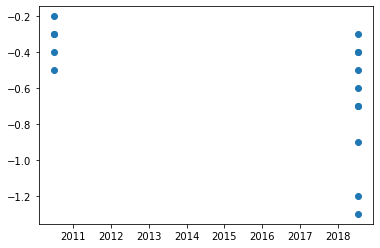

In [46]:
plt.scatter(low_outliers.index,low_outliers['TEMPERATURE'])
plt.show()

Now that we know what the upper and lower caps are, we can apply capping to the outliers. This effectively means that we replace any values which exceed the upper and lower limits are replaced with the upper and lower limit respectively.

In [47]:
final_df['TEMPERATURE'] = np.where(final_df['TEMPERATURE']>temp_highest_allowed,temp_highest_allowed, np.where(final_df['TEMPERATURE']<temp_lowest_allowed,temp_lowest_allowed,final_df['TEMPERATURE']))

In [48]:
final_df_temp_highest = round(final_df['TEMPERATURE'].mean() + 3*final_df['TEMPERATURE'].std(),2)
final_df_temp_lowest = round(final_df['TEMPERATURE'].mean() - 3*final_df['TEMPERATURE'].std(),2)
print(final_df_temp_highest)
print(final_df_temp_lowest)

35.09
-0.1


## Price

In [49]:
price_highest_allowed = round(final_df['rrp'].mean() + 3*final_df['rrp'].std(),2)
price_lowest_allowed = round(final_df['rrp'].mean() - 3*final_df['rrp'].std(),2)

In [50]:
print(price_highest_allowed)
print(price_lowest_allowed)

533.88
-419.91


In [53]:
price_outliers = final_df[(final_df['rrp']>price_highest_allowed) | (final_df['rrp']<price_lowest_allowed)]
print(len(price_outliers))

151


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


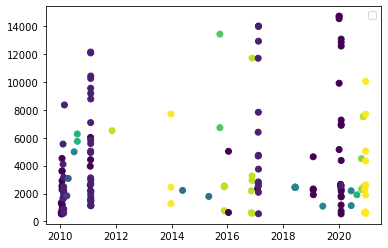

In [54]:
plt.scatter(price_outliers.index, price_outliers['rrp'],c=price_outliers['month'])
plt.legend()
plt.show()

In [55]:
print(price_outliers['month'].value_counts())

2     53
1     50
11    14
12    14
6      9
8      3
5      2
9      2
10     2
3      1
4      1
Name: month, dtype: int64


We can see that the price 'spike' during the months from Nov to Feb which aligns with the temperature outliers.

## Total Demand

In [56]:
total_demand_highest_allowed = round(final_df['TOTALDEMAND'].mean() + 3*final_df['TOTALDEMAND'].std(),2)
total_demand_lowest_allowed = round(final_df['TOTALDEMAND'].mean() - 3*final_df['TOTALDEMAND'].std(),2)
print(total_demand_highest_allowed)
print(total_demand_lowest_allowed)

12010.91
4212.38


In [58]:
total_demand_outliers = final_df[(final_df['TOTALDEMAND']>total_demand_highest_allowed) | (final_df['TOTALDEMAND']<total_demand_lowest_allowed)]
print(len(total_demand_outliers))

871


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


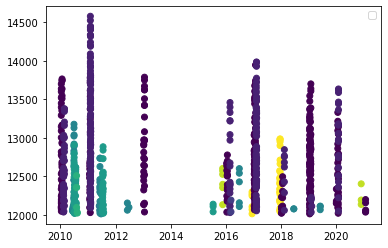

In [59]:
plt.scatter(total_demand_outliers.index, total_demand_outliers['TOTALDEMAND'],c=total_demand_outliers['month'])
plt.legend()
plt.show()

In [60]:
print(total_demand_outliers['month'].value_counts())
#To DO: Sort values by month

1     407
2     279
7      71
6      64
12     32
11      9
8       6
3       2
5       1
Name: month, dtype: int64


Total Demand outliers can be seen during the months from Nov to Feb. 

## Lag Variables (Data Engineering)


In [61]:
# def lag_variable(df, n, var_name):
#     """
#     Creates a lag variable, linear interpolation for NA values created in the shift
#     Parameters:
#         df (dataframe): pandas df
#         n (int): lag size
#         var_name (str): name of variable
        
#     Returns:
#         pd.series with index matching df
#     """
#     #Shifting the variable
#     varShifted = df[var_name].shift(n)
    
#     #Dealing With NA - median of all the other matching timestamps
#     varShifted = varShifted.interpolate(method='linear', limit_direction='both', axis=0)
#     print(varShifted)
    
#     return varShifted

In [62]:
lag_test = final_df['TEMPERATURE'].shift(2)
print(lag_test)

Unnamed: 0
2010-01-01 00:30:00     NaN
2010-01-01 01:00:00     NaN
2010-01-01 01:30:00    22.9
2010-01-01 02:00:00    22.6
2010-01-01 02:30:00    22.5
                       ... 
2021-03-17 22:00:00    19.2
2021-03-17 22:30:00    19.7
2021-03-17 23:00:00    19.7
2021-03-17 23:30:00    19.5
2021-03-18 00:00:00    19.1
Name: TEMPERATURE, Length: 194589, dtype: float64


In [63]:
varShifted = final_df['TEMPERATURE'].shift(2)
varShifted = varShifted.interpolate(method='linear', limit_direction = 'both',axis=0)
print(varShifted)

Unnamed: 0
2010-01-01 00:30:00    22.9
2010-01-01 01:00:00    22.9
2010-01-01 01:30:00    22.9
2010-01-01 02:00:00    22.6
2010-01-01 02:30:00    22.5
                       ... 
2021-03-17 22:00:00    19.2
2021-03-17 22:30:00    19.7
2021-03-17 23:00:00    19.7
2021-03-17 23:30:00    19.5
2021-03-18 00:00:00    19.1
Name: TEMPERATURE, Length: 194589, dtype: float64
